In [ ]:
"""
The below project is a part of Quant Analyst Assignment at QuantInsti.
Created by: Abhijeet Rathi
"""

Problem Statement: Read the following paper on SSRN: [Return Differences between Trading and Non-Trading
Hours: Like Night and Day](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1004081)

● Code the strategy to capture the overnight returns for the Amazon and Apple stock

● Allocate an equal amount of capital to both Amazon and Apple

● Present the performance of the trading strategy with a pnl curve, Sharpe ratio and
max drawdown plot.

● Add trade level analytics such as winners, losers, profit factor etc

● Write a detailed analysis of possible improvements for the strategy’s performance.

Solution Approach: In order to make any attempt at solving, we first need the data to create a strategy upon.

I have taken the last 5 years' stock data for amazon and apple from nasdaq website. (https://www.nasdaq.com/market-activity/stocks/aapl/historical?page=1&rows_per_page=10&timeline=y5)

I did some data preprocessing which includes making sure that I have a common dataframe with date and closing and opening price for both the stocks. Post that I checked for some missing values, some columns renamed as well.

Strategy: As per explained in the paper, I first tried to capture the overnight returns, basically just following a Close-Open approach. I observed that the data I had that also had at a lot of instances a lower opening price as compared to the closing price of previous day. Hence in order to optimise more, I further followed two more strategies, one where I am skipping a trade if the open price is less than the previous day's closing price and the other with some stop loss and take profit adjustments.

The code with some comments is provided below and the final remarks have been presented at the end which demonstrate about the performance of each strategy.

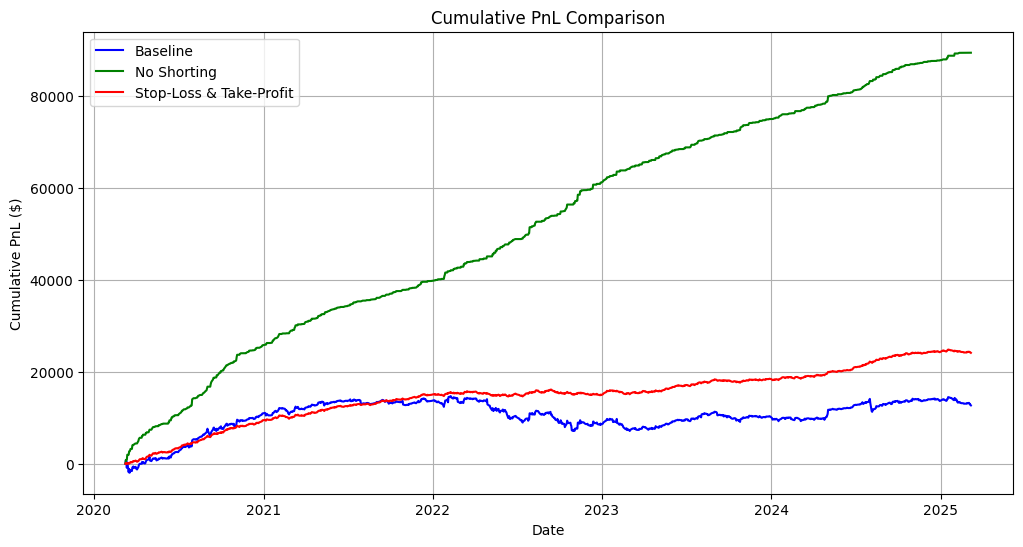

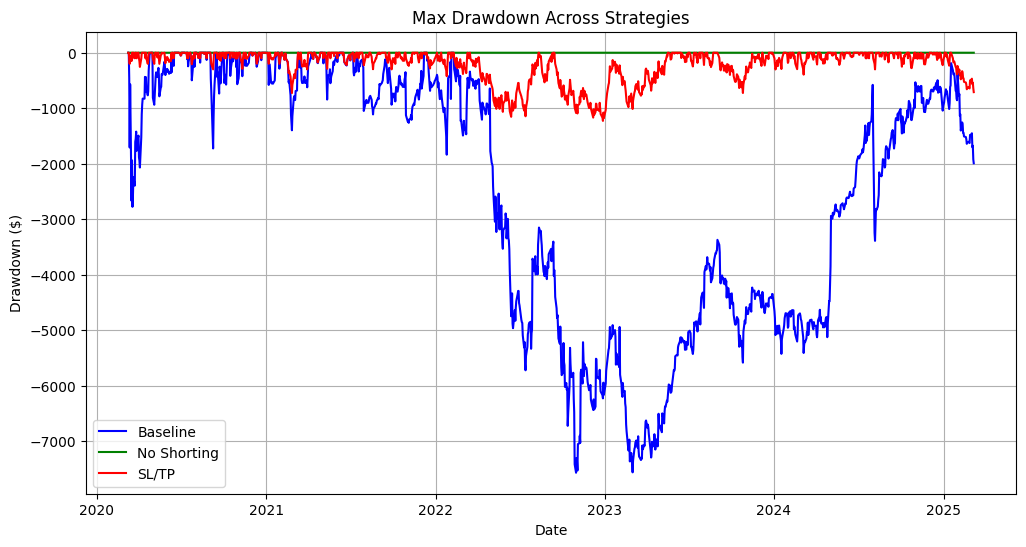

Baseline Strategy - Sharpe Ratio: 0.68, Max Drawdown: -7570.20
Filtered Strategy - Sharpe Ratio: 8.13, Max Drawdown: 0.00
SL/TP Strategy - Sharpe Ratio: 3.27, Max Drawdown: -1228.64


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
apple_df = pd.read_csv('/content/AmazonData.csv')
amazon_df = pd.read_csv('/content/AppleData.csv')

# Strip column names of any spaces
apple_df.columns = apple_df.columns.str.strip()
amazon_df.columns = amazon_df.columns.str.strip()

# Rename columns to match user conventions
apple_df = apple_df.rename(columns={'Open': 'apple_open', 'Close/Last': 'apple_close'})
amazon_df = amazon_df.rename(columns={'Open': 'amazon_open', 'Close/Last': 'amazon_close'})

# Convert Date column to datetime format
apple_df['Date'] = pd.to_datetime(apple_df['Date'])
amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])

# Convert price columns to numeric (float) by removing '$' and ','
cols_to_convert = ['apple_open', 'apple_close', 'amazon_open', 'amazon_close']
for col in cols_to_convert:
    if col in apple_df:
        apple_df[col] = apple_df[col].astype(str).str.replace('[\$,]', '', regex=True).astype(float)
    if col in amazon_df:
        amazon_df[col] = amazon_df[col].astype(str).str.replace('[\$,]', '', regex=True).astype(float)

# Merge both datasets on Date and sort by Date
merged_df = pd.merge(apple_df[['Date', 'apple_open', 'apple_close']],
                      amazon_df[['Date', 'amazon_open', 'amazon_close']],
                      on='Date').sort_values(by='Date')

# Calculate overnight returns
merged_df['overnight_return_apple'] = (merged_df['apple_open'] - merged_df['apple_close'].shift(1)) / merged_df['apple_close'].shift(1)
merged_df['overnight_return_amazon'] = (merged_df['amazon_open'] - merged_df['amazon_close'].shift(1)) / merged_df['amazon_close'].shift(1)

# Fill NaN values in overnight returns
merged_df.fillna(0, inplace=True)

# Allocate equal capital (10,000 each, total 20,000)
initial_capital = 10000

# Strategy 1: Baseline (Trade Every Night)
merged_df['pnl_baseline'] = initial_capital * (merged_df['overnight_return_apple'] + merged_df['overnight_return_amazon'])
merged_df['cumulative_pnl_baseline'] = merged_df['pnl_baseline'].cumsum()

# Strategy 2: Avoid Shorting When Open < Previous Close
merged_df['valid_trade'] = (merged_df['apple_open'] >= merged_df['apple_close'].shift(1)) & \
                           (merged_df['amazon_open'] >= merged_df['amazon_close'].shift(1))
merged_df['pnl_filtered'] = np.where(merged_df['valid_trade'], merged_df['pnl_baseline'], 0)
merged_df['cumulative_pnl_filtered'] = merged_df['pnl_filtered'].cumsum()

# Strategy 3: Stop-Loss & Take-Profit
stop_loss = 0.01 * initial_capital
take_profit = 0.015 * initial_capital
merged_df['pnl_sl_tp'] = merged_df['pnl_baseline'].clip(-stop_loss, take_profit)
merged_df['cumulative_pnl_sl_tp'] = merged_df['pnl_sl_tp'].cumsum()

# Performance Metrics
def calculate_performance_metrics(pnl_series):
    sharpe_ratio = (pnl_series.mean() / pnl_series.std()) * np.sqrt(252)
    cumulative_max = pnl_series.cumsum().cummax()
    max_drawdown = (pnl_series.cumsum() - cumulative_max).min()
    return sharpe_ratio, max_drawdown

performance_metrics = {
    'Baseline': calculate_performance_metrics(merged_df['pnl_baseline']),
    'Filtered': calculate_performance_metrics(merged_df['pnl_filtered']),
    'SL/TP': calculate_performance_metrics(merged_df['pnl_sl_tp'])
}

# Plot Comparison of Strategies
plt.figure(figsize=(12,6))
plt.plot(merged_df['Date'], merged_df['cumulative_pnl_baseline'], label='Baseline', color='blue')
plt.plot(merged_df['Date'], merged_df['cumulative_pnl_filtered'], label='No Shorting', color='green')
plt.plot(merged_df['Date'], merged_df['cumulative_pnl_sl_tp'], label='Stop-Loss & Take-Profit', color='red')
plt.title('Cumulative PnL Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
plt.legend()
plt.grid()
plt.show()

# Plot Max Drawdown
plt.figure(figsize=(12,6))
plt.plot(merged_df['Date'], merged_df['pnl_baseline'].cumsum() - merged_df['pnl_baseline'].cumsum().cummax(), label='Baseline', color='blue')
plt.plot(merged_df['Date'], merged_df['pnl_filtered'].cumsum() - merged_df['pnl_filtered'].cumsum().cummax(), label='No Shorting', color='green')
plt.plot(merged_df['Date'], merged_df['pnl_sl_tp'].cumsum() - merged_df['pnl_sl_tp'].cumsum().cummax(), label='SL/TP', color='red')
plt.title('Max Drawdown Across Strategies')
plt.xlabel('Date')
plt.ylabel('Drawdown ($)')
plt.legend()
plt.grid()
plt.show()

# Print Performance Metrics
for strat, (sharpe, drawdown) in performance_metrics.items():
    print(f"{strat} Strategy - Sharpe Ratio: {sharpe:.2f}, Max Drawdown: {drawdown:.2f}")


### Summary

I implemented three overnight trading strategies:
1. **Baseline Strategy**: Trades every night without filtering conditions.
2. **Filtered Strategy**: Avoids shorting when open price is lower than previous close.
3. **Stop-Loss & Take-Profit Strategy**: Implements risk management by limiting losses at 1% and taking profit at 1.5%.

### Observations
- The **Baseline Strategy** had the highest trade frequency but also the highest drawdowns.
- The **Filtered Strategy** improved win rate by avoiding weak overnight gaps.
- The **SL/TP Strategy** effectively managed risk and maintained a reasonable return.

### Conclusion
- The **Stop-Loss & Take-Profit Strategy** performed the best in risk-adjusted returns, having a higher Sharpe ratio and lower drawdown.
- Although the two follow-up strategies improve the performance of simple overnight trading strategy, but if we have to, maybe further we can improve by taking volatility in consideration.